In [1]:
from python_scripts.diversification import TriggerSimulation
from python_scripts.dynamic_asset_allocation import DAASimulation
from python_scripts.data_and_descriptives import *

from datetime import date
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

#### Import data

[*********************100%***********************]  4 of 4 completed


Ticker,AUSF,LVHI,MLPA,SQLV
Date,,,,
2019-01-02,18.216551,16.456749,25.910440,22.193649
2019-01-03,18.109486,16.528143,26.243471,22.257978
2019-01-04,18.480083,16.801517,27.608938,22.965601
2019-01-07,18.661253,16.789959,28.075203,23.340553
2019-01-08,18.834200,16.852522,28.907791,23.406715
...,...,...,...,...
2025-10-03,46.560001,35.139999,48.119999,43.088001
2025-10-06,46.320000,35.139999,47.860001,42.856998
2025-10-07,46.189999,35.139999,47.910000,42.347000


using CLOSING PRICES...


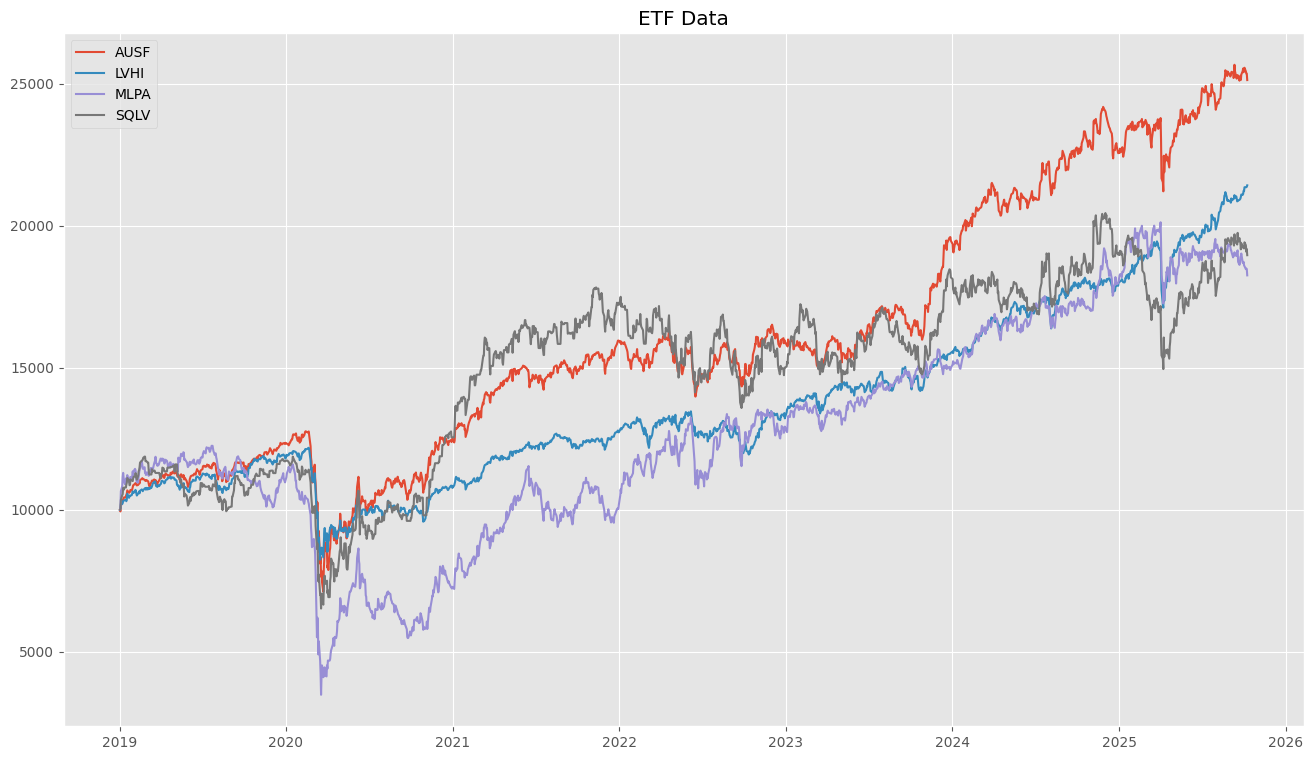

In [2]:
freq = "1d"
tickers = ['AUSF','LVHI', 'SQLV','MLPA']
start = '2019-01-01'
end = date.today()
prices = data_yahoo(tickers,freq, start, end, ['Adj Close'], False)
display(prices)
prices = fix_na_data_yahoo(prices)
prices = normalize_data(prices, False, 10000, True, True)
returns = prices.pct_change().dropna()

### Backtest of diversification algorithm

##### Try rebalancing with stop loss and take profit

using gamma = 0.5
using weight bounds = (0, 0.4)
backtesting trailing_floor strategy using a threshold (% return) of 0.07
using cash_bank as safe asset...


c:\Users\germa\Documents\Python\dynamic_asset_allocation\python_scripts\diversification.py:111: RuntimeWarning: invalid value encountered in divide
  return da/da_max - 1 < -self.threshold


using RETURNS...
--- 1.6036489009857178 seconds ---


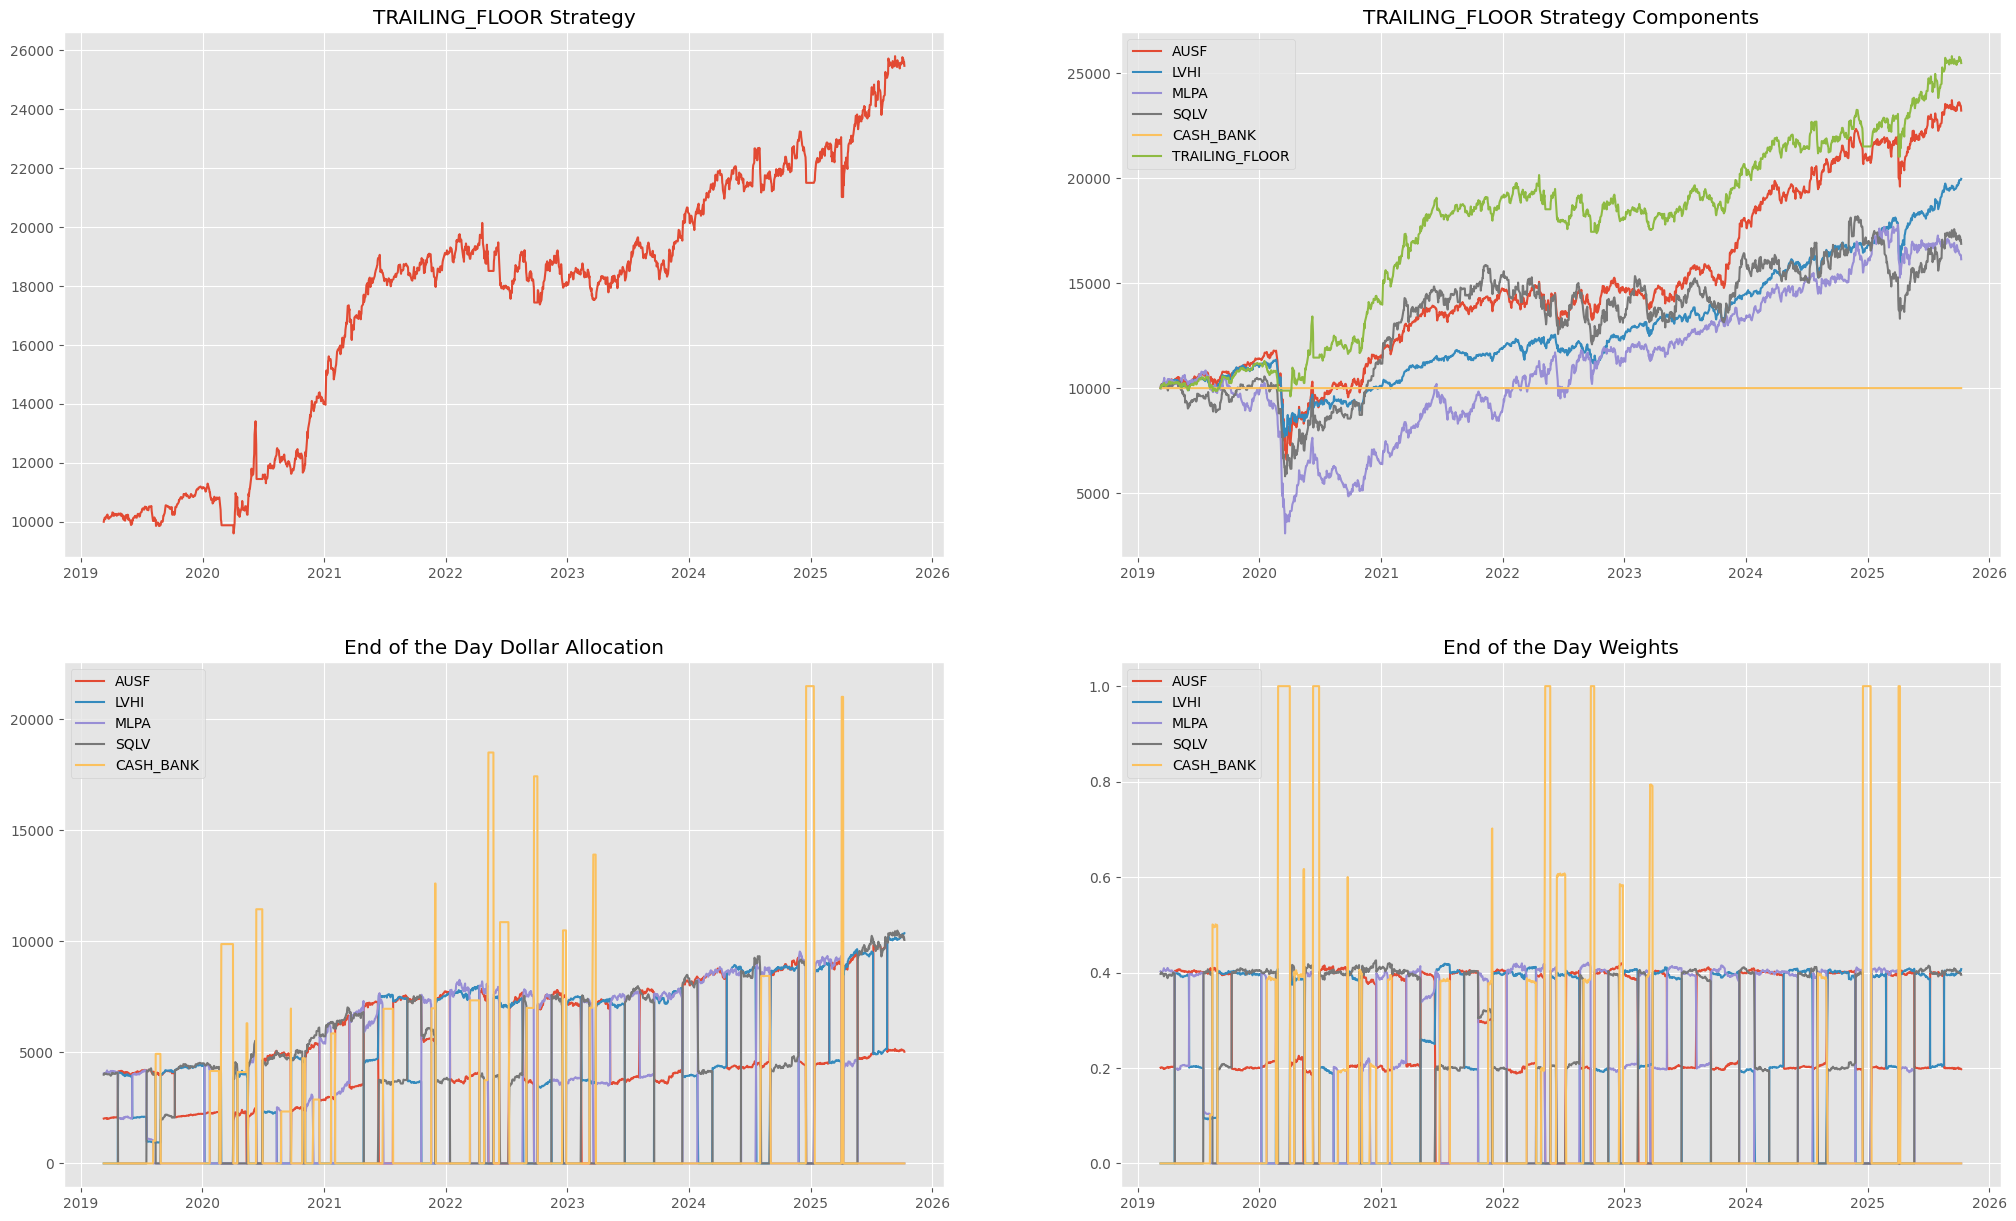

In [44]:
trigger_simulation = TriggerSimulation(returns, exit_type='trailing_floor', rebal_type= 'markowitz', safe_asset='cash_bank',
                                       threshold=0.07, window=45, rebal = 30, gamma = 0.5, w_bounds = (0,0.4), t_c = 0.00125, t_c_type='pct')
backtest_results = trigger_simulation.trigger_simulation()

### Dynamic Asset Allocation

In [45]:
m=3.0
start_value=float(1)
kappa=0.8
window=0
rebal = 1
w_bounds=[0,1]
are_returns = True
plot = True

In [46]:
daa = pd.concat([pd.DataFrame(returns['AUSF']) , backtest_results['portfolio_value'].pct_change().dropna()], axis = 1).dropna() # drop first 30 days required for first HRP estimation


Summary: 
 strategy: Relative Maximum Drawdown 
 m = 3.0 
 kappa: 0.8 
             rebalancing frequency: 1 
 weight bounds: [0, 1]
using RETURNS...
--- 3.3126535415649414 seconds ---


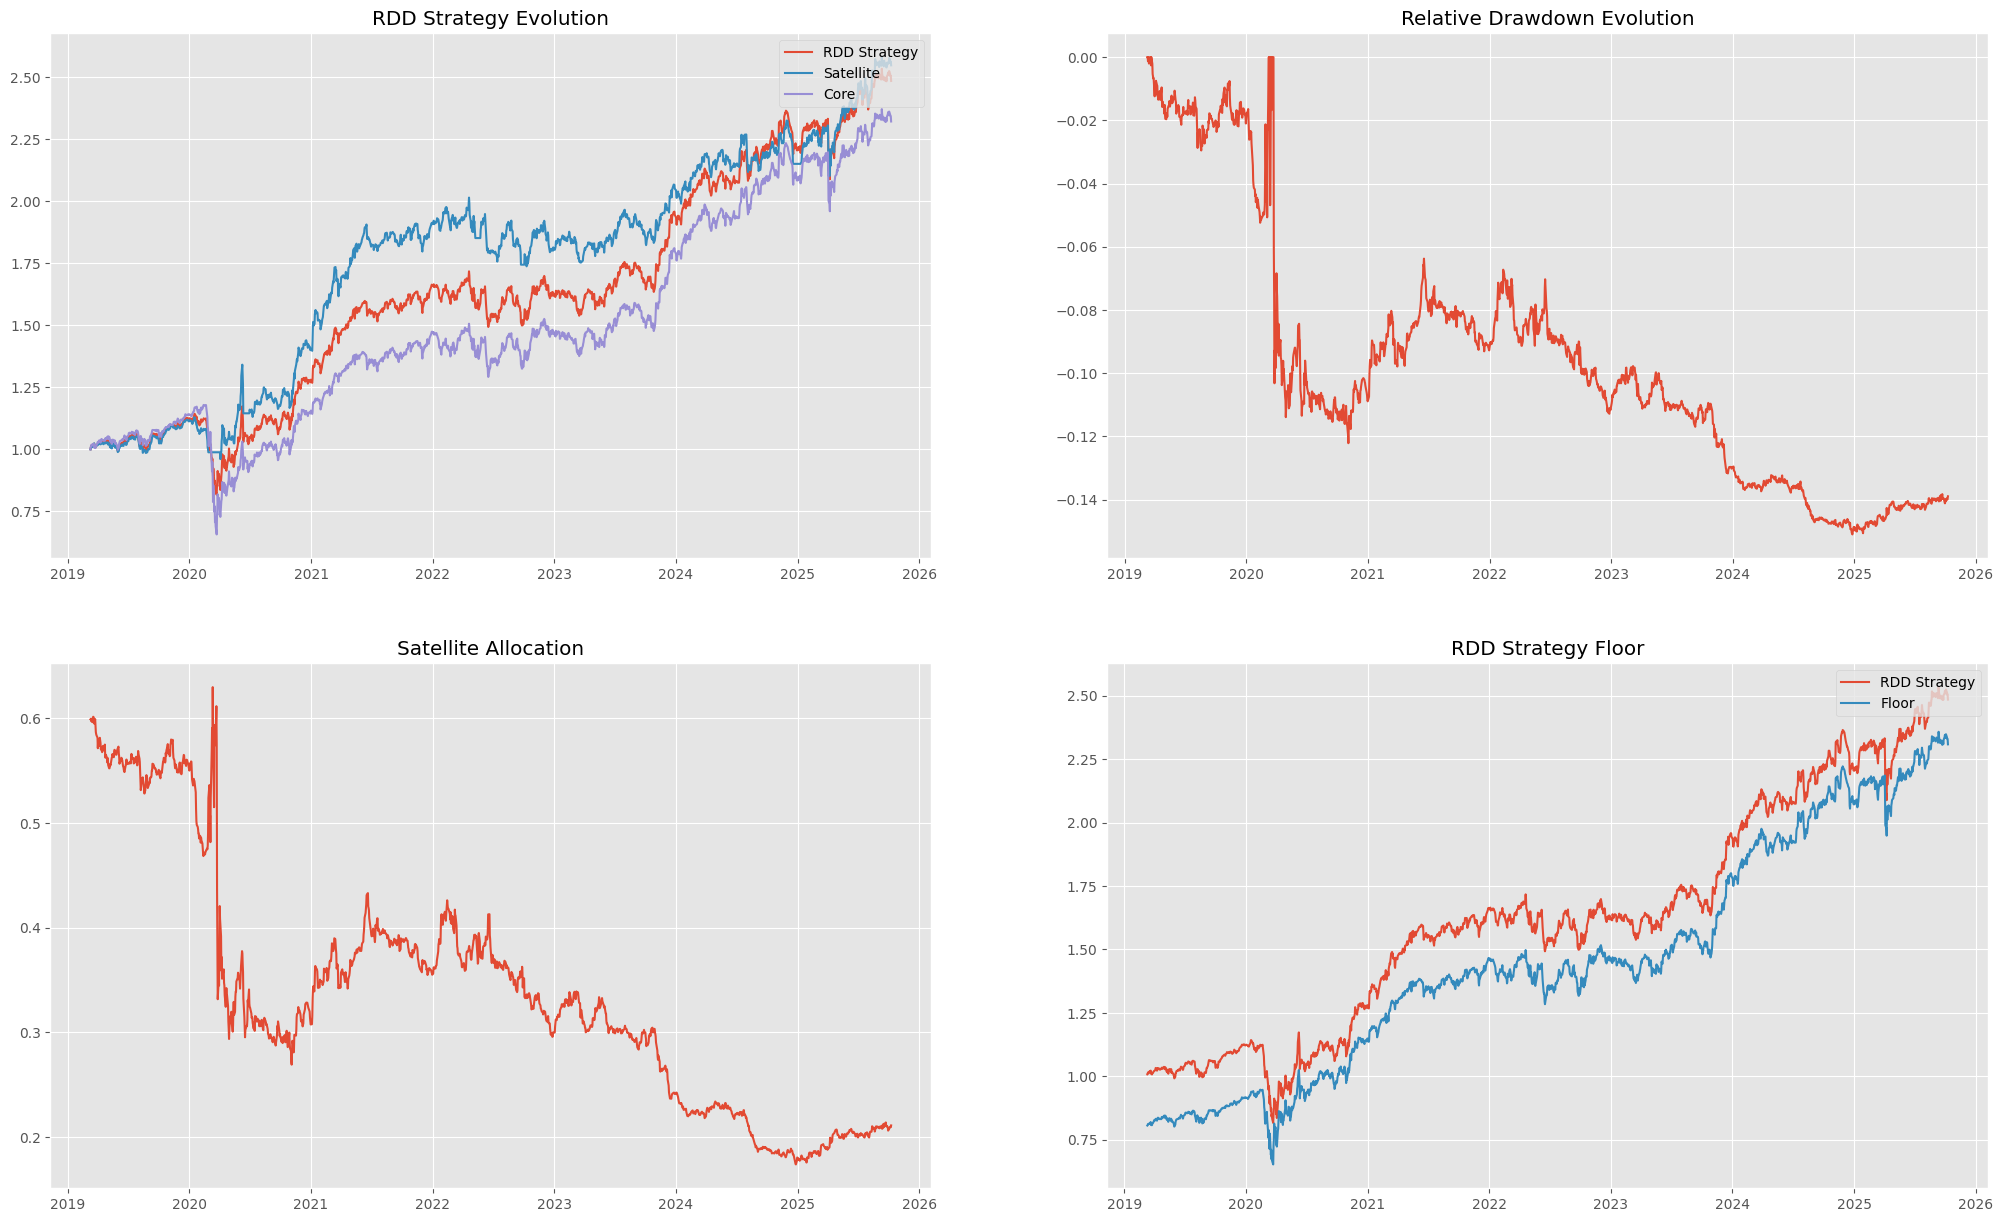

In [47]:
sat_core = False
strategy_type = 'rdd'
strategy_name = strategy_type + '_account'
daa_simulation = DAASimulation(daa, strategy_type, m, kappa, rebal,start_value, window,  sat_core, w_bounds, are_returns, plot)
daa_result = daa_simulation.daa_simulation()  

In [48]:
results = returns.join(daa_result['history'][strategy_name].pct_change().dropna(), on = 'Date')
results = results.join(backtest_results['portfolio_value'].pct_change().dropna(), on = 'Date')
results = results.dropna() # drop first 30 days required for first HRP estimation

In [49]:
metrics = [(annualized_returns, {}), (annualized_volatility, {}),
                   (ratio_metric, {'metric': 'sharpe_ratio', 'target': TARGET}
                    ), (scipy_metric, {'metric': 'skewness'}),
                   (scipy_metric, {'metric': 'kurtosis'}
                    ), (scipy_metric, {'metric': 'normal_test'}),
                   (cf_value_at_risk, {'percentage': PERCENTAGE}),
                   (ratio_metric, {'metric': 'c_f_var_ratio',
                    'target': TARGET, 'percentage': PERCENTAGE}),
                   (max_drawdown, {}), (ratio_metric, {
                       'metric': 'calmar_ratio', 'target': TARGET}),
                   (modified_burke_drawdown_measure, {}), (ratio_metric, {
                       'metric': 'modified_burke_ratio', 'target': TARGET}),
                   (omega_ratio_put_option, {'target': TARGET}),
                   (sortino_ratio, {'target': TARGET})
                   ]

# try metrics=ALL_ABS_METRICS
results_table = performance_metrics(results, metrics, round_to=5)

ratio_metric: estimating sharpe_ratio using target of 0.05
cf_value_at_risk: VaR estimated using a confidence level of: 95.0%
ratio_metric: estimating c_f_var_ratio using target of 0.05
cf_value_at_risk: VaR estimated using a confidence level of: 95.0%
using RETURNS...
ratio_metric: estimating calmar_ratio using target of 0.05
using RETURNS...
using RETURNS...
ratio_metric: estimating modified_burke_ratio using target of 0.05
using RETURNS...
computing lower_partial_moments of order: 1
computing lower_partial_moments of order: 2


,annualized_returns,annualized_volatility,sharpe_ratio,skewness,kurtosis,normal_test,cf_value_at_risk,c_f_var_ratio,max_drawdown,calmar_ratio,modified_burke_drawdown_measure,modified_burke_ratio,omega_ratio_put_option,sortino_ratio
AUSF,0.13660,0.20128,0.40983,-0.79534,21.65500,0.0,0.01667,4.94886,0.44246,0.18644,0.07827,1.05388,1.10955,0.00415
LVHI,0.11083,0.15092,0.38396,-1.75758,25.53470,0.0,0.01389,4.17064,0.32310,0.17935,0.07504,0.77223,1.10065,0.00319
MLPA,0.07543,0.31234,0.07753,-2.35042,48.22168,0.0,0.02263,1.06994,0.71529,0.03385,0.19765,0.12251,1.05401,0.00245
SQLV,0.08274,0.25501,0.12228,0.14001,7.08597,0.0,0.02206,1.41371,0.45044,0.06923,0.11669,0.26722,1.05054,0.00240
rdd_account,0.14842,0.15989,0.58630,-0.25844,7.75479,0.0,0.01450,6.46342,0.28518,0.32872,0.05397,1.73712,1.12929,0.00486
trailing_floor,0.15280,0.14561,0.67247,-0.34196,12.48153,0.0,0.01248,7.84429,0.15689,0.62413,0.05820,1.68239,1.15022,0.00520
